In [1]:
import os
from difflib import SequenceMatcher

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
import nltk

from scipy.stats import chi2
import csv
from statsmodels.graphics.factorplots import interaction_plot

from scipy import stats
from sklearn.preprocessing import StandardScaler

Resources:

Book: Extending the linear model with R
Book: Nonparametric regression models for longitudinal data analysis
choosing family and link function: https://stats.stackexchange.com/questions/190763/how-to-decide-which-glm-family-to-use
Unstructured covariance structure in statsmodels package:
https://github.com/statsmodels/statsmodels/issues/7005
Blog on GEE in R:
https://rlbarter.github.io/Practical-Statistics/2017/05/10/generalized-estimating-equations-gee/
Intro to GEEs:
https://online.stat.psu.edu/stat504/lesson/12/12.1
Book: Longitudinal data analysis
https://onlinelibrary.wiley.com/doi/full/10.1002/sim.6947 - applying GEES to longitudinal data with missing data points
GEE methods: https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_estimating_equations.GEEResults.html#statsmodels.genmod.generalized_estimating_equations.GEEResults

In [2]:
home = 0
if home:
    infiledir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\Processed_2"
    rand_dir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis"
else:
    infiledir = r"P:\EW_analysis\analysis\Processed_2"
    rand_dir = r"P:\EW_analysis\analysis"

In [31]:
all_dat_df = pd.read_csv(os.path.join(infiledir, 'all_dat_df.csv')) # read in data
# column to denote whether or not they reported the same stressful events for the ADNM-20 at each time point
all_dat_df['same_event'] = 0
# if spacy version suggests >0.8 similarity, set to 1 (inspection showed that this seems to be a reasonable cut-off.)
all_dat_df.loc[all_dat_df.most_stressful_similarity2>0.8,'same_event'] = 1
all_dat_df.loc[(all_dat_df.most_stressful_similarity>0.2)&(all_dat_df.most_stressful_similarity2<0.8),'same_event'] = 1 # also set to 1 if spacy is below the cut-off, but SequenceMatcher is higher than 0.2 (seemed like a reasonable cutoff)
all_dat_df.loc[(all_dat_df.order==1),'same_event']=np.nan

all_dat_df['time'] = all_dat_df.order
all_dat_df.loc[all_dat_df.order==1,'time'] = 0
all_dat_df.loc[all_dat_df.order==2,'time'] = 2
all_dat_df.loc[all_dat_df.order==3,'time'] = 4
all_dat_df.loc[all_dat_df.order==4,'time'] = 12

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#all_dat_df.loc[:,'time'] = scaler.fit_transform(all_dat_df['time'].values.reshape(-1,1))

Because the assessments were re-used at different time points, we collected the trait measures multiple times from each participant. We therefore want to set the trait measures to baseline levels.

In [32]:
#all_dat_df['ADNM_baseline'] = np.nan
#all_dat_df['dass_depression_baseline'] = np.nan
#all_dat_df['dass_anxiety_baseline'] = np.nan
#all_dat_df['dass_stress_baseline'] = np.nan

for i, pnum in enumerate(all_dat_df.id.unique()):
    val_reapp = all_dat_df.loc[(all_dat_df.id==pnum)&(all_dat_df.order==1),'ERQ_reapp'].iloc[0]
    val_sup = all_dat_df.loc[(all_dat_df.id==pnum)&(all_dat_df.order==1),'ERQ_sup'].iloc[0]
    val_rrs = all_dat_df.loc[(all_dat_df.id==pnum)&(all_dat_df.order==1),'RRS_total'].iloc[0]
    #val_ADNM_bl = all_dat_df.loc[(all_dat_df.id==pnum)&(all_dat_df.order==1),'ADNM_burden_total'].iloc[0]
    #val_dassd_bl = all_dat_df.loc[(all_dat_df.id==pnum)&(all_dat_df.order==1),'dass_depression'].iloc[0]
    #val_dassa_bl = all_dat_df.loc[(all_dat_df.id==pnum)&(all_dat_df.order==1),'dass_anxiety'].iloc[0]
    #val_dasss_bl = all_dat_df.loc[(all_dat_df.id==pnum)&(all_dat_df.order==1),'dass_stress'].iloc[0]
    all_dat_df.loc[(all_dat_df.id==pnum)&(all_dat_df.order.isin([2,3,4])), 'ERQ_reapp'] = val_reapp
    all_dat_df.loc[(all_dat_df.id==pnum)&(all_dat_df.order.isin([2,3,4])), 'ERQ_sup'] = val_sup
    all_dat_df.loc[(all_dat_df.id==pnum)&(all_dat_df.order.isin([2,3,4])), 'RRS_total'] = val_rrs
    #all_dat_df.loc[(all_dat_df.id==pnum), 'dass_depression_baseline'] = val_dassd_bl
    #all_dat_df.loc[(all_dat_df.id==pnum), 'ADNM_baseline'] = val_ADNM_bl
    #all_dat_df.loc[(all_dat_df.id==pnum), 'dass_anxiety_baseline'] = val_dassa_bl
    #all_dat_df.loc[(all_dat_df.id==pnum), 'dass_stress_baseline'] = val_dasss_bl

Before doing anything else, check the number of NaNs for relevant features/zeros and their meanings.

In [33]:
sub_frame = all_dat_df.loc[:,['ADNM_burden_total','order','id','dass_depression','dass_anxiety','dass_stress']]
sub_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469 entries, 0 to 468
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ADNM_burden_total  465 non-null    float64
 1   order              469 non-null    float64
 2   id                 469 non-null    float64
 3   dass_depression    469 non-null    int64  
 4   dass_anxiety       469 non-null    int64  
 5   dass_stress        469 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 22.1 KB


Based on the above, only ADNM_burden_total has missing values (only 4). One of them is P015, who completed the ADNM in one of the follow-up assessments using a separate link. We will add his results here. Note the use of '.values' here - this is because of indexing issues. You could also use '.reset_index()' instead. The important thing is to get rid of the 0-index on the RHS so that the assignment can proceed.

In [34]:
P15_ADNM = pd.read_csv(os.path.join(rand_dir, 'P15_task2_ADNM_20.csv'), skiprows=[0,2])
col_keys = pd.read_csv(os.path.join(rand_dir, 'survey_cols.csv'))
ADNM_cols = P15_ADNM.iloc[:,19:].columns
ADNM_items = ADNM_cols[~ADNM_cols.str.contains('How long')]
ADNM_preoccupation = ['I have to think about the stressful situation repeatedly.',
'I have to think about the stressful situation a lot and this is a great burden to me.',
"I constantly get memories of the stressful situation and can't do anything to stop them.",
'My thoughts often revolve around anything related to the stressful situation.']

ADNM_failure = ['Since the stressful situation, I find it difficult to concentrate on certain things.',
'Since the stressful situation, I do not like going to work or carrying out the necessary tasks in everyday life.',
'Since the situation, I can no longer sleep properly.',
'All in all, the situation causes serious impairment in my social or occupational life, my leisure time and other important areas of functioning.']

ADNM_depression = ['Since the stressful situation, I feel low and sad.',
'I rarely do those activities which I used to enjoy anymore.',
'I have been feeling dispirited since the stressful situation and have little hope for the future.']

ADNM_anxiety = ['If I think about the stressful situation, I find myself in a real state of anxiety.',
'Since the stressful situation, I am scared of doing certain things or of getting into certain situations.']

ADNM_impulse = ['I am nervous and restless since the stressful situation.',
'Since the stressful situation, I lose my temper much quicker than I used to, even over small things.',
'I have noticed that I am becoming more irritable due to the stressful situation.']

ADNM_avoidance = ['I try to avoid talking about the stressful situation whenever possible.',
'I avoid certain things that might remind me of the stressful situation.',
'I try to dismiss the stressful situation from my memory.',
'I try to suppress my feelings because they are a burden to me.']

P15_ADNM.loc[:,ADNM_cols] = P15_ADNM.loc[:,ADNM_cols].replace({'Never':1, 'Rarely':2,'Sometimes':3,'Often':4,'<1 month':1,'1-3 months':2, '3-6 months':3, 'more than 6 months':4})
all_dat_df.loc[(all_dat_df.id == 15) & (all_dat_df.task_type == 2),['ADNM_time_total']] = P15_ADNM.filter(like = 'How long have you had this reaction for?', axis = 1).sum(axis = 1).values
all_dat_df.loc[(all_dat_df.id == 15) & (all_dat_df.task_type == 2),['ADNM_burden_total']] = P15_ADNM.filter(items = ADNM_items, axis = 1).sum(axis = 1).values
all_dat_df.loc[(all_dat_df.id == 15) & (all_dat_df.task_type == 2),['ADNM_preoccupation']] = P15_ADNM.filter(items = ADNM_preoccupation,axis = 1).sum(axis = 1).values
all_dat_df.loc[(all_dat_df.id == 15) & (all_dat_df.task_type == 2),['ADNM_failure']] = P15_ADNM.filter(items = ADNM_failure,axis = 1).sum(axis = 1).values
all_dat_df.loc[(all_dat_df.id == 15) & (all_dat_df.task_type == 2),['ADNM_anxiety']] = P15_ADNM.filter(items = ADNM_anxiety,axis = 1).sum(axis = 1).values
all_dat_df.loc[(all_dat_df.id == 15) & (all_dat_df.task_type == 2),['ADNM_depression']] = P15_ADNM.filter(items = ADNM_depression,axis = 1).sum(axis = 1).values
all_dat_df.loc[(all_dat_df.id == 15) & (all_dat_df.task_type == 2),['ADNM_impulse']] = P15_ADNM.filter(items = ADNM_impulse,axis = 1).sum(axis = 1).values
all_dat_df.loc[(all_dat_df.id == 15) & (all_dat_df.task_type == 2),['ADNM_avoidance']] = P15_ADNM.filter(items = ADNM_avoidance,axis = 1).sum(axis = 1).values

In [35]:
sub_frame = all_dat_df.loc[:,['ADNM_burden_total','order','id','dass_depression','dass_anxiety','dass_stress']]
sub_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469 entries, 0 to 468
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ADNM_burden_total  466 non-null    float64
 1   order              469 non-null    float64
 2   id                 469 non-null    float64
 3   dass_depression    469 non-null    int64  
 4   dass_anxiety       469 non-null    int64  
 5   dass_stress        469 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 22.1 KB


In [36]:
all_dat_df.loc[all_dat_df.ADNM_burden_total.isna(),'id']

269     72.0
276    113.0
304     23.0
Name: id, dtype: float64

Participants who did not report any stressful events at a given follow-upt time point will have a zero score. This is because, when scoring, strings were replaced with the appropriate score numbers. For someone who had not completed the assessment, this would still in a nan value, because non-existent records are of course not affected by the replacement operation. When replacing strings, an 'all other' condition was applied, setting values 0 where none of the other conditions were met so as to avoid problems with mixed data types in the columns. 0s are therefore meaningful, because they indicate that a participant did not report any stressful events.

Let's now have a look at the distribution of ADNM-20 scores. We plot a KDE plot first. Then we'll have a look at the Q-Q plot, plotting ADNM scores against both a normal and gamma distribution to see what provides the best fit. Note the single outlier, which is visible in both plots.

<AxesSubplot:xlabel='ADNM_burden_total', ylabel='Density'>

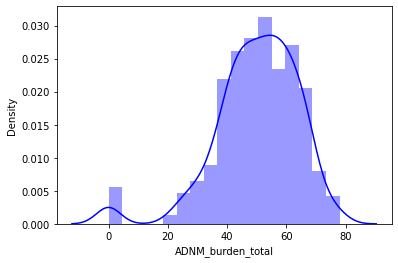

In [37]:
# for all time points lumped together
sns.distplot(all_dat_df.loc[:,'ADNM_burden_total'],color = 'b')

50.122317596566525 14.054921998964865


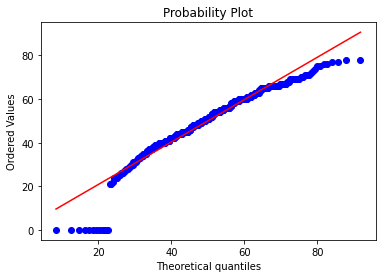

In [38]:
loc, scale = stats.distributions.norm.fit(all_dat_df.ADNM_burden_total.dropna())
print(loc, scale)

fig, ax = plt.subplots()
stats.probplot(all_dat_df.ADNM_burden_total.dropna(), dist=stats.distributions.norm, sparams=(loc,scale), plot=ax)
plt.show()

184.2452302932719 -150.12792504734512 1.0862247561006892


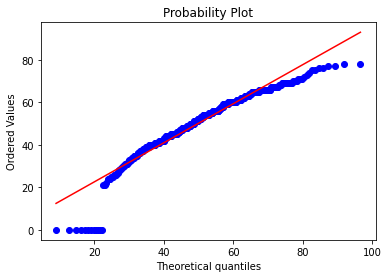

In [39]:
shape, loc, scale = stats.distributions.gamma.fit(all_dat_df.ADNM_burden_total.dropna())
print(shape,loc, scale)

fig, ax = plt.subplots()
stats.probplot(all_dat_df.ADNM_burden_total.dropna(), dist=stats.distributions.gamma, sparams=(shape,loc,scale), plot=ax)
plt.show()

We can see that the zeros affect the shape of the distribution quite a bit. This makes sense because scores were generally moderate - high (a condition for participating in the study was to have moderate-high scores at baseline). We will run with the normal distribution for GEEs, although Gamma is also worth a try. We can investigate the effect on fit further when we do GEE diagnostics later on.

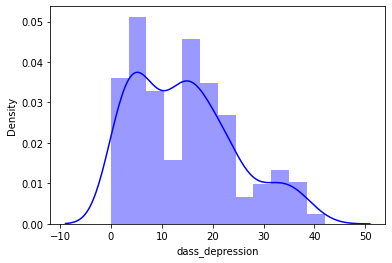

In [40]:
# kde plots of DASS-21 scores at each time point
sns.distplot(all_dat_df.dass_depression,color = 'b') 
plt.show()

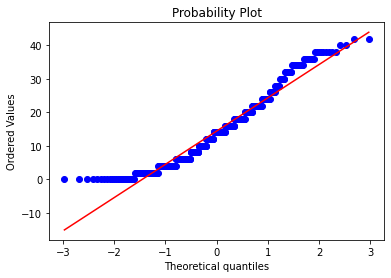

Skewness: 0.615671
Kurtosis: -0.344488


In [149]:
fig = plt.figure()
res = stats.probplot(all_dat_df.dass_depression, plot=plt)
plt.show()

print("Skewness: %f" % all_dat_df.dass_depression.skew())
print("Kurtosis: %f" % all_dat_df.dass_depression.kurt())

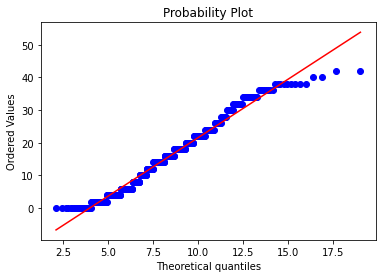

In [160]:
fig = plt.figure()
res = stats.probplot(all_dat_df.dass_depression,dist = stats.gamma,sparams = (8), plot=plt)
plt.show()

We can see that the scores pool into bins. This is because the DASS-21 scores are multiplied by 2, so we only get even values.

Because of the discrete nature and the pooling into bins, we check the fit for a negative binomial distribution. We make a plot of this below - it's ugly, but it'll do for the moment.

In [174]:
def discreteQQ(x_sample):

    p_test = np.array([])
    for i in range(0, 1001):
        p_test = np.append(p_test, i/1000)
        i = i + 1

    x_sample = np.sort(x_sample)
    x_theor = stats.nbinom.rvs(5,.5, size=len(x_sample))
    ecdf_sample = np.arange(1, len(x_sample) + 1)/(len(x_sample)+1)

    x_theor = stats.nbinom.ppf(ecdf_sample,5, p=0.5)

    for p in p_test:
        plt.scatter(np.quantile(x_theor, p), np.quantile(x_sample, p), c = 'blue')

    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Sample quantiles')
    plt.show()

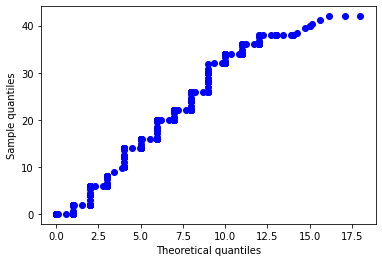

In [175]:
discreteQQ(all_dat_df.dass_depression)

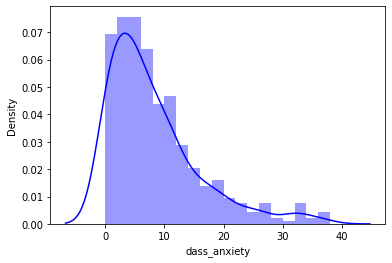

In [15]:
# kde plots of DASS-21 scores at each time point
sns.distplot(all_dat_df.dass_anxiety,color = 'b') 
plt.show()

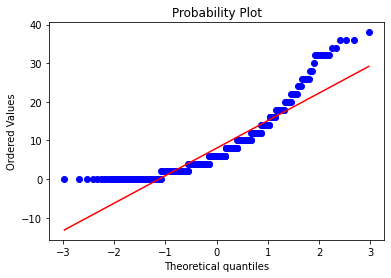

Skewness: 1.500135
Kurtosis: 2.267860


In [180]:
fig = plt.figure()
res = stats.probplot(all_dat_df.dass_anxiety, plot=plt)
plt.show()

print("Skewness: %f" % all_dat_df.dass_anxiety.skew())
print("Kurtosis: %f" % all_dat_df.dass_anxiety.kurt())

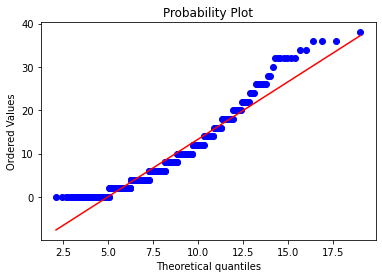

In [181]:
fig = plt.figure()
res = stats.probplot(all_dat_df.dass_anxiety,dist = stats.gamma,sparams = (8), plot=plt)
plt.show()

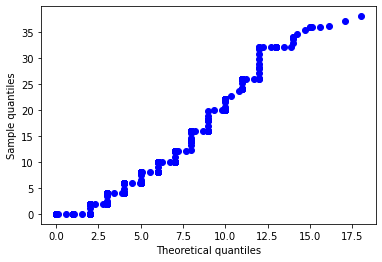

In [182]:
discreteQQ(all_dat_df.dass_anxiety)

In [183]:
all_dat_df.dass_anxiety.describe()

count    469.000000
mean       8.012793
std        7.678909
min        0.000000
25%        2.000000
50%        6.000000
75%       10.000000
max       38.000000
Name: dass_anxiety, dtype: float64

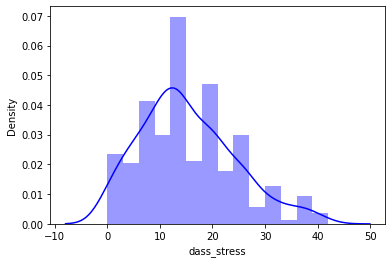

In [177]:
sns.distplot(all_dat_df.dass_stress,color = 'b') 
plt.show()

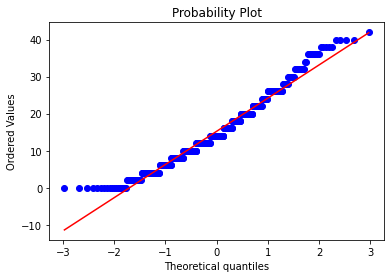

Skewness: 0.551596
Kurtosis: -0.060525


In [187]:
fig = plt.figure()
res = stats.probplot(all_dat_df.dass_stress, plot=plt)
plt.show()

print("Skewness: %f" % all_dat_df.dass_stress.skew())
print("Kurtosis: %f" % all_dat_df.dass_stress.kurt())

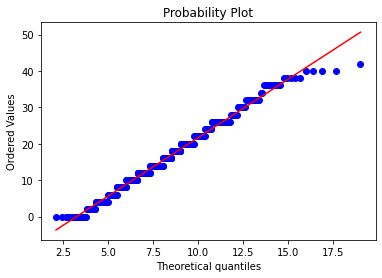

In [188]:
fig = plt.figure()
res = stats.probplot(all_dat_df.dass_stress,dist = stats.gamma,sparams = (8), plot=plt)
plt.show()

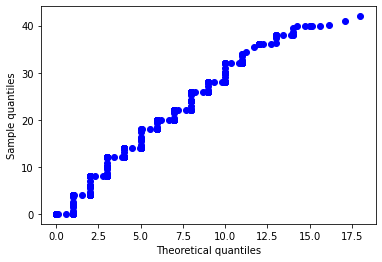

In [184]:
discreteQQ(all_dat_df.dass_stress)

In [185]:
all_dat_df.dass_stress.describe()

count    469.000000
mean      15.228145
std        9.064417
min        0.000000
25%        8.000000
50%       14.000000
75%       20.000000
max       42.000000
Name: dass_stress, dtype: float64

The below just wraps some of the modelling stuff up into a function to save a few lines of code later on.

In [43]:
def get_res(df,group,md_f, re_f):
    model = smf.mixedlm(md_f, df, groups = group, missing = 'drop',re_formula = re_f)
    model = model.fit()
    results = model.summary()
    pvalues = model.pvalues
    llf = model.llf
    return results, pvalues, llf,model

Let's now also quickly have a look at the mean trajectories over time for each group/scale.

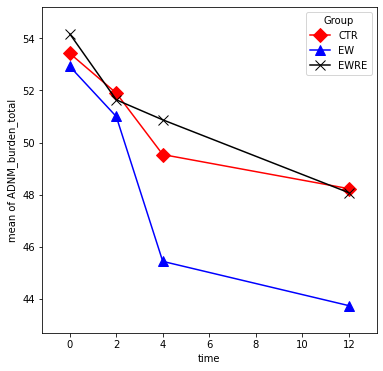

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(
    x=all_dat_df.time,
    trace=all_dat_df.Group,
    response=all_dat_df.ADNM_burden_total,
    colors=["red", "blue","black"],
    markers=["D", "^",'x'],
    ms=10,
    ax=ax,
)

The above is heavily affected by the 0 scores, as can be seen from the figure below.

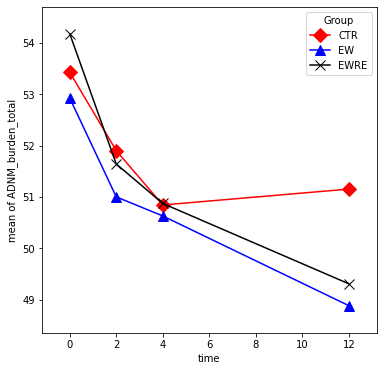

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(
    x=all_dat_df.time,
    trace=all_dat_df.Group,
    response=all_dat_df.loc[all_dat_df.ADNM_burden_total>0,'ADNM_burden_total'],
    colors=["red", "blue","black"],
    markers=["D", "^",'x'],
    ms=10,
    ax=ax,
)

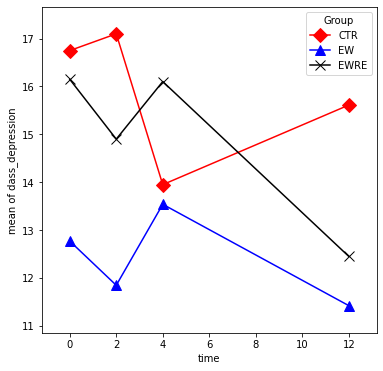

In [190]:
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(
    x=all_dat_df.time,
    trace=all_dat_df.Group,
    response=all_dat_df.dass_depression,
    colors=["red", "blue","black"],
    markers=["D", "^",'x'],
    ms=10,
    ax=ax,
)

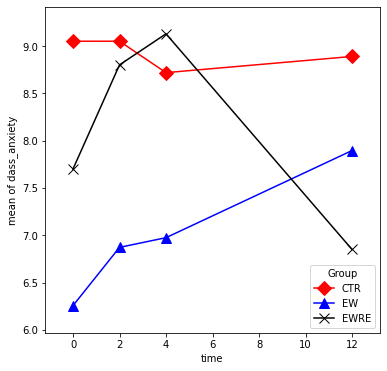

In [191]:
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(
    x=all_dat_df.time,
    trace=all_dat_df.Group,
    response=all_dat_df.dass_anxiety,
    colors=["red", "blue","black"],
    markers=["D", "^",'x'],
    ms=10,
    ax=ax,
)

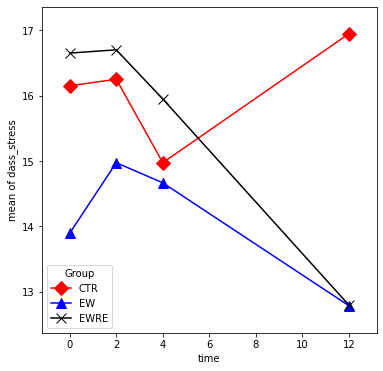

In [193]:
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(
    x=all_dat_df.time,
    trace=all_dat_df.Group,
    response=all_dat_df.dass_stress,
    colors=["red", "blue","black"],
    markers=["D", "^",'x'],
    ms=10,
    ax=ax,
)

Now let's have a look at mean trajectories, irrespective of writing condition. The below shows that there isn't really that much change overall between the different assessment time points.

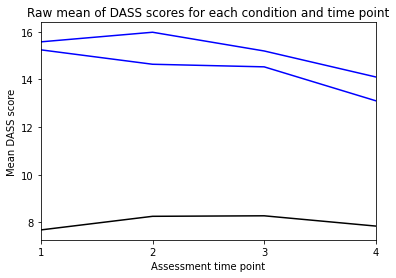

In [220]:
all_mean = all_dat_df.groupby('order').dass_anxiety.mean()

xax = np.arange(1,5)
plt.plot(xax,all_mean, color = 'k')
plt.plot(xax,all_dat_df.groupby('order').dass_stress.mean(), color = 'b')
plt.plot(xax,all_dat_df.groupby('order').dass_depression.mean(), color = 'b')
plt.xlabel('Assessment time point')
plt.ylabel('Mean DASS score')

plt.xticks([1,2,3,4])

plt.xlim([1,4])
#plt.ylim([10,20])
plt.title('Raw mean of DASS scores for each condition and time point')
plt.show()


The below does not take into account different groups/within-participant correlation in scores. But overall, the scores seem stable over time.

In [206]:
stats.f_oneway(all_dat_df.loc[all_dat_df.order == 1,'dass_anxiety'],
               all_dat_df.loc[all_dat_df.order==2,'dass_anxiety'],
               all_dat_df.loc[all_dat_df.order == 3, 'dass_anxiety'],
               all_dat_df.loc[all_dat_df.order == 4, 'dass_anxiety'])

F_onewayResult(statistic=0.1755258590990125, pvalue=0.9129553213227994)

In [207]:
stats.f_oneway(all_dat_df.loc[all_dat_df.order == 1,'dass_stress'],
               all_dat_df.loc[all_dat_df.order==2,'dass_stress'],
               all_dat_df.loc[all_dat_df.order == 3, 'dass_stress'],
               all_dat_df.loc[all_dat_df.order == 4, 'dass_stress'])

F_onewayResult(statistic=0.9180706887942655, pvalue=0.43195832686519287)

In [208]:
stats.f_oneway(all_dat_df.loc[all_dat_df.order == 1,'dass_depression'],
               all_dat_df.loc[all_dat_df.order==2,'dass_depression'],
               all_dat_df.loc[all_dat_df.order == 3, 'dass_depression'],
               all_dat_df.loc[all_dat_df.order == 4, 'dass_depression'])

F_onewayResult(statistic=0.9195152860775259, pvalue=0.4312371798181276)

Reference on Contrast coding in Statsmodels:
https://www.statsmodels.org/dev/examples/notebooks/generated/contrasts.html

We'll include time as a categorical variable in the analysis.

In [48]:
ADNM20_res, ADNM20_pvals,ADNM20_llf,ADNM20_model = get_res(all_dat_df,'id',"ADNM_burden_total ~ C(time) + C(Group, Treatment('CTR'))", "~1+C(time)")
print(ADNM20_res)

                     Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      ADNM_burden_total
No. Observations:        466          Method:                  REML             
No. Groups:              119          Scale:                   34.3557          
Min. group size:         2            Log-Likelihood:          -1774.9306       
Max. group size:         4            Converged:               Yes              
Mean group size:         3.9                                                    
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                             53.682    1.447 37.104 0.000 50.846 56.518
C(time)[T.2.0]                        -2.080    0.887 -2.345 0.019 -3.819 -0.342
C(time)[T.4.0]                        -4.875    1.

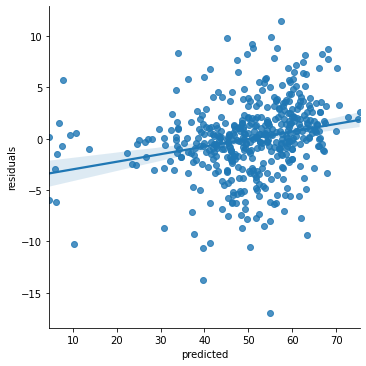

In [49]:
performance = pd.DataFrame()
performance["residuals"] = ADNM20_model.resid.values
#performance["order"] = all_dat_df.order
performance["predicted"] = ADNM20_model.fittedvalues

sns.lmplot(x = "predicted", y = "residuals",  data = performance)

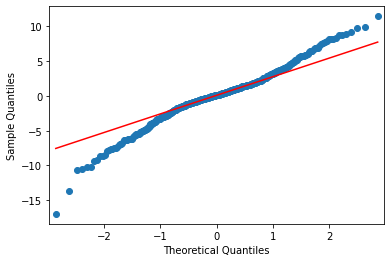

In [50]:
res = ADNM20_model.resid.values # residuals with a qq plot
fig = sm.qqplot(res,line = 'q')
fig.show()

Dropping the interaction between writing condition and time, we get a significant effect of time for all 3 follow-up time points. Note the QQ plot. This indicates that the assumption that residulas are normally distributed is violated. This is mostly due to the 0s.

We will now proceed to model ADNM scores using GEEs. To do so, we have to pick an appropriate response distribution, covariance structure and possibly link function, although the default will be the canonical link for each distribution, which is usually a good initial choice.

In [67]:
# From the initial plots, we know that the normal distribution or the gamma may provide a good fit. We look at both and inspect.
model_norm_adnm = smf.gee("ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Gaussian(),missing = 'drop').fit()
model_gamma_adnm = smf.gee("ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Gamma(),missing = 'drop').fit()

In [52]:
print(model_norm_adnm.aic, model_norm_adnm.deviance, model_norm_adnm.null_deviance, model_norm_adnm.scale, model_norm_adnm.qic())
print(model_gamma_adnm.aic, model_gamma_adnm.deviance, model_gamma_adnm.null_deviance, model_gamma_adnm.scale, model_gamma_adnm.qic())

3788.0168998741296 87868.62255495129 92054.02789699571 193.54322148667674 (478.3358974852312, 477.9999999886577)
-inf 867.5027471554723 867.1365044888136 0.082766770584728 (88786.84068403541, 31537.42460248743)


In [63]:
model_norm_adnm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: GEE
===================================================================================================
Model:                           GEE                          AIC:                       3788.0169 
Link Function:                   identity                     BIC:                       85079.1623
Dependent Variable:              ADNM_burden_total            Log-Likelihood:            -1882.0   
Date:                            2021-10-26 13:12             LL-Null:                   -1892.9   
No. Observations:                466                          Deviance:                  87869.    
Df Model:                        11                           Pearson chi2:              8.79e+04  
Df Residuals:                    454                          Scale:                     193.54    
Method:                          IRLS                                                              
---------------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------------------------
Intercept                                          52.9568   1.7012 31.1290 0.0000  49.6225 56.2910
C(time)[T.2.0]                                     -1.9028   1.9111 -0.9957 0.3194  -5.6485  1.8428
C(time)[T.4.0]                                     -3.1981   2.2899 -1.3966 0.1625  -7.6862  1.2900
C(time)[T.12.0]                                    -4.6452   2.8339 -1.6392 0.1012 -10.1995  0.9091
C(Group, Treatment('CTR'))[T.EW]                   -0.1300   2.2108 -0.0588 0.9531  -4.4631  4.2030
C(Group, Treatment('CTR'))[T.EWRE]                 -0.3017   2.2521 -0.1340 0.8934  -4.7158  4.1124
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]     1.2919   2.6460  0.4882 0.6254  -3.8942  6.4779
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]    -4.1836   3.4434 -1.2150 0.2244 -10.9325  2.5653
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]   -4.3182   4.0830 -1.0576 0.2902 -12.3208  3.6844
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]   0.7137   2.6259  0.2718 0.7858  -4.4331  5.8604
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]   1.4217   2.8731  0.4948 0.6207  -4.2095  7.0529
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE]  0.3605   3.6930  0.0976 0.9222  -6.8775  7.5986
===================================================================================================

"""

In [74]:
gee_res_df = all_dat_df.loc[:,['ADNM_burden_total','id','time','Group']]
drop_inds = gee_res_df.loc[gee_res_df.ADNM_burden_total.isna(),:].index.values
gee_res_df = gee_res_df.drop(labels = drop_inds, axis = 0)

In [76]:
gee_res_df['resid_dev'] = model_norm_adnm.resid_deviance
gee_res_df['fitted'] = model_norm_adnm.fittedvalues

<AxesSubplot:xlabel='ADNM_burden_total', ylabel='Density'>

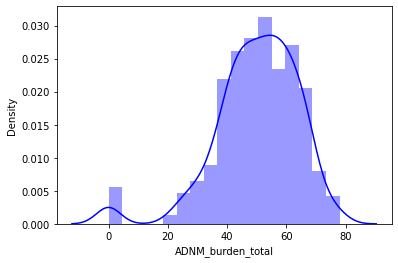

In [53]:
sns.distplot(all_dat_df.ADNM_burden_total,color = 'b')

<AxesSubplot:ylabel='Density'>

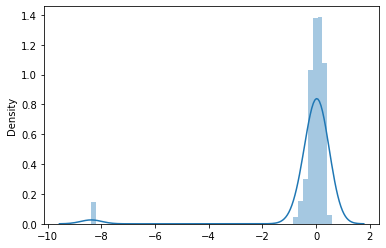

In [58]:
# kde plot of deviance residuals
sns.distplot(model_gamma_adnm.resid_deviance)

<AxesSubplot:ylabel='Density'>

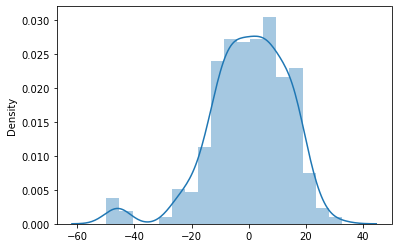

In [59]:
sns.distplot(model_norm_adnm.resid_deviance)

<AxesSubplot:ylabel='Density'>

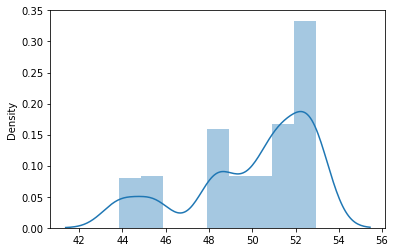

In [60]:
# and fitted values.
sns.distplot(model_norm_adnm.fittedvalues)

<AxesSubplot:ylabel='Density'>

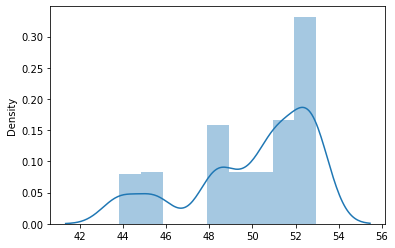

In [61]:
sns.distplot(model_gamma_adnm.fittedvalues)

Plotting fitted against residuals. Note that residuals need not be normally distributed for GEEs. We are looking for two main things:
(i) Are there any obvious non-linearities?
(ii) Inspect the variance of the residuals with respect to the fitted values. Look for non-constant variance, which would require a change in the model.
Heree things look decent apart from the obvs outlier.

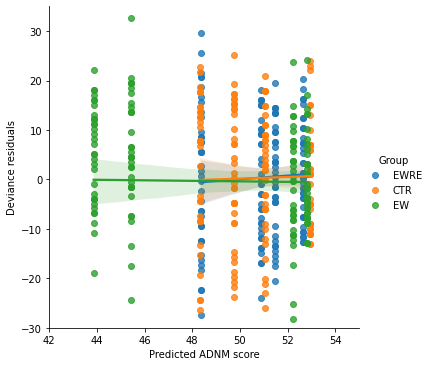

In [90]:
g = sns.lmplot(x = "fitted", y = "resid_dev", hue = "Group", data = gee_res_df)
g = (g.set_axis_labels("Predicted ADNM score", "Deviance residuals").set(xlim=(42, 55), ylim=(-30, 35)))

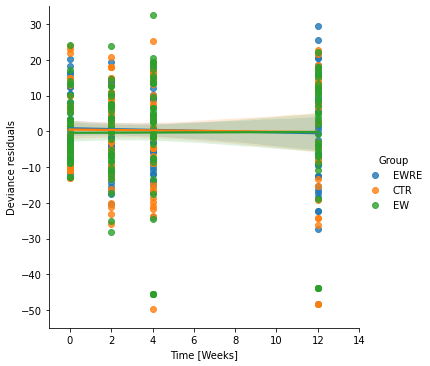

In [85]:
g = sns.lmplot(x = "time", y = "resid_dev", hue = "Group", data = gee_res_df)
g = (g.set_axis_labels("Time [Weeks]", "Deviance residuals").set(xlim=(-1, 14), ylim=(-55, 35)))

In [ ]:
# Calculate Cook's distance. This attempts to answer the question, "If we exclude participant X from the analysis, how would the coefficient estimates be affected?"
# We'll do the following: Exclude participant x - repeat analysis - calculate change in coefficients (abs) - record - repeat, excluding next participan in line.
# This will take ages for more complex models but I couldn't find an implementation I was happy with.
all_params = []
all_ids = []
for i,pnum in enumerate(all_dat_df.id.unique()):
    # eliminate id from dataframe
    red_df = all_dat_df.drop(labels = all_dat_df.loc[all_dat_df.id == pnum].index.values,axis = 0)
    # fit model
    model_norm_adnm_red = smf.gee("ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR'))","id", red_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Gaussian(),missing = 'drop').fit()
    # get coefficients
    id_mcoeffs = model_norm_adnm_red.params
    all_params.append(id_mcoeffs)
    all_ids.append(pnum)


In [288]:
# Calculate Cook's distance. This attempts to answer the question, "If we exclude participant X from the analysis, how would the coefficient estimates be affected?"
# We'll do the following: Exclude participant x - repeat analysis - calculate change in coefficients (abs) - record - repeat, excluding next participan in line.
# This will take ages for more complex models but I couldn't find an implementation I was happy with.
cooks_dist = []
all_ids = []
for i,pnum in enumerate(all_dat_df.id.unique()):
    # eliminate id from dataframe
    red_df = all_dat_df.drop(labels = all_dat_df.loc[all_dat_df.id == pnum].index.values,axis = 0)
    # fit model
    model_norm_adnm_red = smf.gee("ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR'))","id", red_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Gaussian(),missing = 'drop').fit()
    # get coefficients
    diff_full = model_norm_adnm.fittedvalues-model_norm_adnm_red.fittedvalues
    cooks_d = np.sum(np.square(diff_full))/model_norm_adnm.deviance
    cooks_dist.append(cooks_d)
    all_ids.append(pnum)

In [291]:
cooks_distance_df = pd.DataFrame({'id':all_ids,'cooks_distance':cooks_dist})

In [292]:
cooks_distance_df.head()

,id,cooks_distance
0,6.0,0.000405
1,9.0,0.000165
2,21.0,0.000009
3,13.0,0.000102
4,14.0,0.000023


In [172]:
# Now put the results into a dataframe

cooks_df = pd.DataFrame(all_params)
print(cooks_df.shape)
cooks_df['id'] = all_ids
cooks_df.set_index('id',inplace = True)
cooks_df = cooks_df.T
# subtract the full model coeffs and get absolute value
cooks_dist_df = cooks_df.subtract(model_norm_adnm.params,axis = 0).applymap(abs)
# add a row with mean for all coeffs
cooks_dist_df.loc['mean_vals',:] = cooks_dist_df.mean().values
cooks_dist_df = cooks_dist_df.T

(119, 12)


In [198]:
cooks_dist_df.index

Index(['Intercept', 'C(time)[T.2.0]', 'C(time)[T.4.0]', 'C(time)[T.12.0]',
       'C(Group, Treatment('CTR'))[T.EW]',
       'C(Group, Treatment('CTR'))[T.EWRE]',
       'C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]',
       'C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]',
       'C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]',
       'C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]',
       'C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]',
       'C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE]', 'mean',
       'mean_vals'],
      dtype='object')

Text(0, 0.5, "cook's distance (?)")

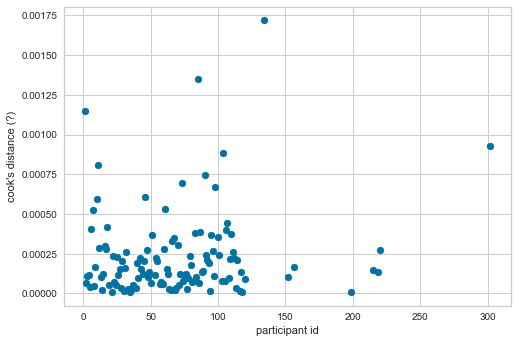

In [299]:
plt.scatter(cooks_distance_df.id,cooks_distance_df.cooks_distance)
plt.xlabel("participant id")
plt.ylabel("cook's distance (?)")


In [300]:
# to calculate the threshold, we use the formula 3p/(n*T), where p = number of predictors, n = number of clusters, T = number of measurements for each cluster
thresh_cal = (3*2)/(119*4)
print(thresh_cal)
# Way to high. Possibly I got this wrong. I'll just choose a threshold by inspection for the moment.
thresh = 0.0005
subs_to_remove = cooks_distance_df[cooks_distance_df.cooks_distance>thresh].index.values
print(subs_to_remove)
inds_to_drop = all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),:].index.values
# now remove and re-run analysis:
model_norm_adnm_red = smf.gee("ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df.drop(labels = inds_to_drop, axis = 0), cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Gaussian(),missing = 'drop').fit()

0.012605042016806723
[12 22 30 32 44 52 61 72 81 84 88 89 93]


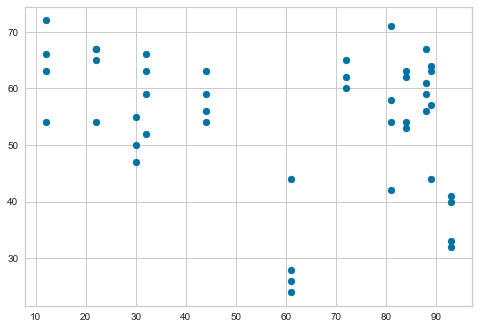

In [301]:
plt.scatter(all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),'id'],all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),'ADNM_burden_total'])

The above shows the ADNM values for above-threshold participants. As we can see, we are catching some of the 0s here (3 out of 12), but I would have thought this would be more. Thins to investigate here would be to check whether those participants with 0s who don't show up here also had low-ish values at the other follow-up time points, so maybe that would have fit the model better?
We are catching the really high scores, which is good. The one thing to bear in mind is that we are seeing scores for all time points lumped together in the above plot, so even if there are mid-of-the-range scores, it might be the pattern over time that is unusual/outlier-ish.
An initial guess (that needs to be verified) is that super-high to super-low (start off at 80, finish at 0) might be an issue.

In [302]:
all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),['ADNM_burden_total','order','id']].set_index('id').sort_index().reset_index()

,id,ADNM_burden_total,order
0,12.0,66.0,3.0
1,12.0,54.0,1.0
2,12.0,72.0,2.0
3,12.0,63.0,4.0
4,22.0,65.0,2.0
5,22.0,54.0,1.0
6,22.0,67.0,3.0
7,22.0,67.0,4.0
8,30.0,47.0,1.0
9,30.0,50.0,4.0


302: Dropped to 0
104: Almost constant 1-3, dropped to 0
95: started out high, but relatively believable drop
80: Increased from baseline to fu1, then fairly constant
73: fairly, constant, but 0 for fu2 - chekc randomisation sheet to see if there is anything unusual
66,48: Went up, not down
18: Fairly consistent drop from 40-ish over time, see nothing unusual. Check if on boundary?

In [303]:
print(model_norm_adnm_red.qic())
print(model_norm_adnm.qic())

(432.1380000834183, 431.9999999898067)
(478.3358974852312, 477.9999999886577)


In [304]:
model_norm_adnm_red.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: GEE
===================================================================================================
Model:                           GEE                          AIC:                       3423.8758 
Link Function:                   identity                     BIC:                       78140.8942
Dependent Variable:              ADNM_burden_total            Log-Likelihood:            -1699.9   
Date:                            2021-10-26 17:05             LL-Null:                   -1709.8   
No. Observations:                420                          Deviance:                  80605.    
Df Model:                        11                           Pearson chi2:              8.06e+04  
Df Residuals:                    408                          Scale:                     197.56    
Method:                          IRLS                                                              
---------------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------------------------
Intercept                                          52.5944   1.8008 29.2059 0.0000  49.0648 56.1239
C(time)[T.2.0]                                     -1.9977   1.9679 -1.0151 0.3100  -5.8547  1.8593
C(time)[T.4.0]                                     -3.2600   2.4993 -1.3043 0.1921  -8.1586  1.6386
C(time)[T.12.0]                                    -4.0679   3.0212 -1.3464 0.1782  -9.9893  1.8536
C(Group, Treatment('CTR'))[T.EW]                    0.1133   2.3029  0.0492 0.9607  -4.4002  4.6269
C(Group, Treatment('CTR'))[T.EWRE]                 -0.2618   2.4191 -0.1082 0.9138  -5.0032  4.4796
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]     1.1906   2.7698  0.4299 0.6673  -4.2380  6.6192
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]    -4.1896   3.7026 -1.1315 0.2578 -11.4466  3.0675
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]   -5.4239   4.3854 -1.2368 0.2162 -14.0192  3.1714
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]   0.0097   2.7366  0.0036 0.9972  -5.3539  5.3733
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]   0.3207   3.0760  0.1043 0.9170  -5.7082  6.3495
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE] -0.7263   3.9553 -0.1836 0.8543  -8.4785  7.0258
===================================================================================================

"""

In [305]:
model_norm_adnm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: GEE
===================================================================================================
Model:                           GEE                          AIC:                       3788.0169 
Link Function:                   identity                     BIC:                       85079.1623
Dependent Variable:              ADNM_burden_total            Log-Likelihood:            -1882.0   
Date:                            2021-10-26 17:06             LL-Null:                   -1892.9   
No. Observations:                466                          Deviance:                  87869.    
Df Model:                        11                           Pearson chi2:              8.79e+04  
Df Residuals:                    454                          Scale:                     193.54    
Method:                          IRLS                                                              
---------------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------------------------
Intercept                                          52.9568   1.7012 31.1290 0.0000  49.6225 56.2910
C(time)[T.2.0]                                     -1.9028   1.9111 -0.9957 0.3194  -5.6485  1.8428
C(time)[T.4.0]                                     -3.1981   2.2899 -1.3966 0.1625  -7.6862  1.2900
C(time)[T.12.0]                                    -4.6452   2.8339 -1.6392 0.1012 -10.1995  0.9091
C(Group, Treatment('CTR'))[T.EW]                   -0.1300   2.2108 -0.0588 0.9531  -4.4631  4.2030
C(Group, Treatment('CTR'))[T.EWRE]                 -0.3017   2.2521 -0.1340 0.8934  -4.7158  4.1124
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]     1.2919   2.6460  0.4882 0.6254  -3.8942  6.4779
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]    -4.1836   3.4434 -1.2150 0.2244 -10.9325  2.5653
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]   -4.3182   4.0830 -1.0576 0.2902 -12.3208  3.6844
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]   0.7137   2.6259  0.2718 0.7858  -4.4331  5.8604
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]   1.4217   2.8731  0.4948 0.6207  -4.2095  7.0529
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE]  0.3605   3.6930  0.0976 0.9222  -6.8775  7.5986
===================================================================================================

"""

As we can see, the interpretation of the results has not changed.

<AxesSubplot:xlabel='cooks_distance', ylabel='Density'>

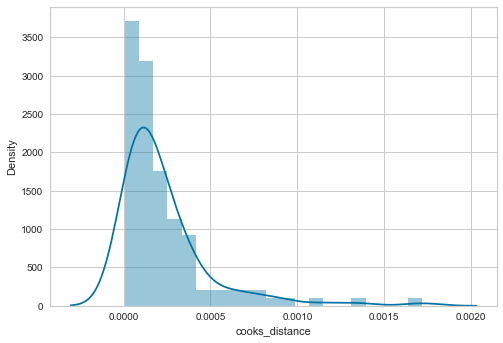

In [296]:
sns.distplot(cooks_distance_df.cooks_distance)

In [159]:
all_params[0].reset_index(drop = True)

0     52.966548
1     -1.903476
2     -3.209022
3     -4.654967
4     -0.144640
5     -0.036281
6      1.281355
7     -4.174485
8     -4.303343
9      0.886348
10     1.746108
11     0.645578
dtype: float64

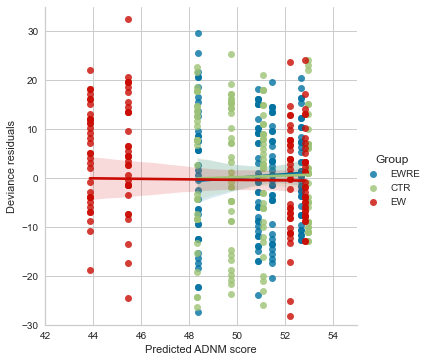

In [306]:
g = sns.lmplot(x = "fitted", y = "resid_dev", hue = "Group", data = gee_res_df)
g = (g.set_axis_labels("Predicted ADNM score", "Deviance residuals").set(xlim=(42, 55), ylim=(-30, 35)))

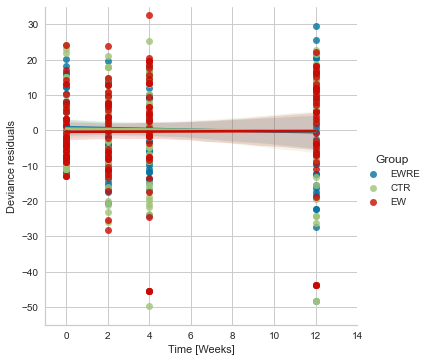

In [307]:
g = sns.lmplot(x = "time", y = "resid_dev", hue = "Group", data = gee_res_df)
g = (g.set_axis_labels("Time [Weeks]", "Deviance residuals").set(xlim=(-1, 14), ylim=(-55, 35)))

We can now check if we see a change when only including participants who always referred to the same event (every time they answered the ADNM 20 questionnaire)

In [308]:
all_dat_df.loc[(all_dat_df.order == 1),'same_event'] = 1

In [309]:
all_ids = []
for i, pnum in enumerate(all_dat_df.id.unique()):
    if all_dat_df.loc[all_dat_df['id']==pnum,'same_event'].sum()==4:
        all_ids.append(pnum)
    else:
        continue

In [265]:
len(all_ids)

55

We use the normal distribution here. As you can see from the results, time is now (just) significant, but the coefficient is infinitesimal and positive, indicating an increase in scores.

In [310]:
model_norm_adnm_re = smf.gee("ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df[all_dat_df.id.isin(all_ids)], cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Gaussian()).fit()

In [311]:
model_norm_adnm_re.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: GEE
===================================================================================================
Model:                           GEE                          AIC:                       1677.3473 
Link Function:                   identity                     BIC:                       22524.5118
Dependent Variable:              ADNM_burden_total            Log-Likelihood:            -826.67   
Date:                            2021-10-26 17:07             LL-Null:                   -832.87   
No. Observations:                220                          Deviance:                  23646.    
Df Model:                        11                           Pearson chi2:              2.36e+04  
Df Residuals:                    208                          Scale:                     113.68    
Method:                          IRLS                                                              
---------------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------------------------
Intercept                                          58.6697   2.8033 20.9291 0.0000  53.1754 64.1640
C(time)[T.2.0]                                     -4.9093   3.2964 -1.4893 0.1364 -11.3701  1.5515
C(time)[T.4.0]                                     -5.1005   3.1319 -1.6286 0.1034 -11.2389  1.0379
C(time)[T.12.0]                                    -8.5813   3.6537 -2.3486 0.0188 -15.7425 -1.4201
C(Group, Treatment('CTR'))[T.EW]                   -2.9614   3.3759 -0.8772 0.3804  -9.5780  3.6552
C(Group, Treatment('CTR'))[T.EWRE]                 -2.6578   3.3772 -0.7870 0.4313  -9.2770  3.9613
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]     3.3707   3.7427  0.9006 0.3678  -3.9650 10.7063
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]     2.8301   3.6248  0.7808 0.4349  -4.2744  9.9346
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]    1.1564   4.1424  0.2792 0.7801  -6.9625  9.2753
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]   1.7664   4.1221  0.4285 0.6683  -6.3126  9.8455
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]   1.8583   3.9537  0.4700 0.6383  -5.8908  9.6073
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE]  1.5485   4.6890  0.3302 0.7412  -7.6418 10.7388
===================================================================================================

"""

Removing the subjects who did not report the same events didn't have that big of an impact. Follow-up3 is now significant, with a drop of about -8.6 from baseline. Other than that we have no significant interactions or main effects.

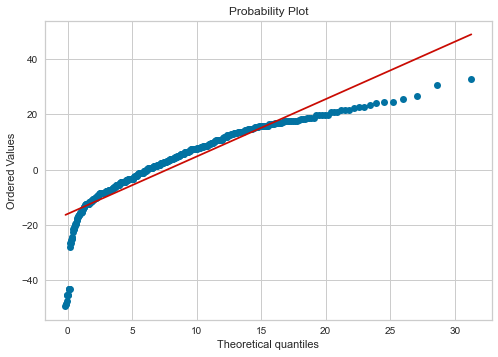

In [313]:
a = model_norm_adnm_red.resid_deviance
a.sort()
fig = plt.figure()
res = stats.probplot(a,dist = stats.halfnorm,sparams = (-0.18,10), plot=plt)
plt.show()

The above looks bad. We are looking for points that are off-trend, of which there are a fair few at the top and lowermost end. I cannot for the life of me get the get_y_hat_matrix and get_influence methods to work for me. These would make it easier to get insight into outliers and check the results when excluding them. I'll investigate if I get a bit of extra time, but it's been driving me crazy and I don't want to waste any more time on it at this point.

Now we repeat, but using an MLM approach.

In [314]:
ADNM20_res, ADNM20_pvals,ADNM20_llf,ADNM20_model_re = get_res(all_dat_df[all_dat_df.id.isin(all_ids)],'id',"ADNM_burden_total ~ time * C(Group, Treatment('CTR'))", "~1+time")
print(ADNM20_res)

                      Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       ADNM_burden_total
No. Observations:        220           Method:                   REML             
No. Groups:              55            Scale:                    41.0600          
Min. group size:         4             Log-Likelihood:           -777.7239        
Max. group size:         4             Converged:                Yes              
Mean group size:         4.0                                                      
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               55.805    2.085 26.762 0.000 51.718 59.892
C(Group, Treatment('CTR'))[T.EW]        -0.429    2.866 -0.150 0.881 -6.046  5.188
C(Group, Treatment('CTR'))[

We can see that the coefficient is ballpark what was reported in the GEE (Gaussian) results. The p value is borderline (in)significant, but it's not a very interesting finding, anyways.

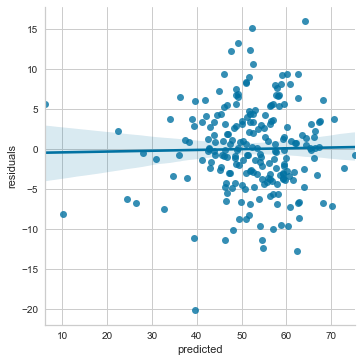

In [315]:
performance = pd.DataFrame()
performance["residuals"] = ADNM20_model_re.resid.values
#performance["order"] = all_dat_df.order
performance["predicted"] = ADNM20_model.fittedvalues

sns.lmplot(x = "predicted", y = "residuals",  data = performance)

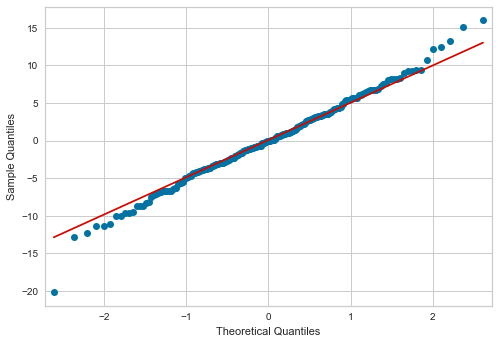

In [316]:
res = ADNM20_model_re.resid.values # residuals with a qq plot
fig = sm.qqplot(res,line = 'q')
fig.show()

From the above we can see that, even if we only use data from those participants who were stressed out by the same event consistently, there is no effect of writing group. The effect of time is just about significant (if rounding down), but that's really not much to write home about.

DASS subscales

Let's use the MLM approach first.

In [319]:
dassd_res, dassd_pvals,dassd_llf,dassd_model = get_res(all_dat_df,'id',"dass_depression ~ C(time) + C(Group, Treatment('CTR'))", "~1+C(time)")
print(dassd_res)

                     Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       dass_depression
No. Observations:        469           Method:                   REML           
No. Groups:              119           Scale:                    26.1081        
Min. group size:         2             Log-Likelihood:           -1652.1099     
Max. group size:         4             Converged:                Yes            
Mean group size:         3.9                                                    
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                             17.110    1.426 12.002 0.000 14.316 19.905
C(time)[T.2.0]                        -0.605    0.783 -0.773 0.440 -2.140  0.930
C(time)[T.4.0]                        -0.674    0.

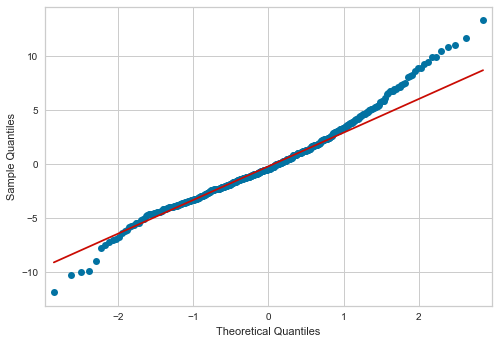

In [320]:
res = dassd_model.resid.values # residuals with a qq plot
fig = sm.qqplot(res,line = 'q')
fig.show()

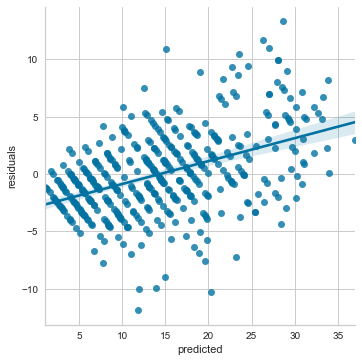

In [321]:
performance = pd.DataFrame()
performance["residuals"] = dassd_model.resid.values
#performance["order"] = all_dat_df.order
performance["predicted"] = dassd_model.fittedvalues

sns.lmplot(x = "predicted", y = "residuals",  data = performance)

In [328]:
model_norm_dassd= smf.gee("dass_depression ~ C(time) + C(Group, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Gaussian()).fit()
model_gamma_dassd = smf.gee("dass_depression~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Independence(), family = sm.families.Gamma()).fit()

In [329]:
model_norm_dassd.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: GEE
==================================================================================
Model:                     GEE                    AIC:                  3503.7434 
Link Function:             identity               BIC:                  44147.7869
Dependent Variable:        dass_depression        Log-Likelihood:       -1745.9   
Date:                      2021-10-26 17:36       LL-Null:              -1752.1   
No. Observations:          469                    Deviance:             46996.    
Df Model:                  5                      Pearson chi2:         4.70e+04  
Df Residuals:              463                    Scale:                101.50    
Method:                    IRLS                                                   
----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                          16.7605   1.3898 12.0600 0.0000 14.0366 19.4844
C(time)[T.2.0]                     -0.5340   0.9081 -0.5881 0.5565 -2.3138  1.2457
C(time)[T.4.0]                     -1.0077   1.0242 -0.9838 0.3252 -3.0151  0.9998
C(time)[T.12.0]                    -2.1234   1.1320 -1.8758 0.0607 -4.3422  0.0953
C(Group, Treatment('CTR'))[T.EW]   -3.6141   1.7624 -2.0507 0.0403 -7.0683 -0.1598
C(Group, Treatment('CTR'))[T.EWRE] -0.8156   1.8153 -0.4493 0.6532 -4.3735  2.7424
==================================================================================

"""

In [331]:
dassa_res, dassa_pvals,dassa_llf,dassa_model = get_res(all_dat_df,'id',"dass_anxiety ~ C(time) + C(Group, Treatment('CTR'))", "~1+C(time)")
print(dassa_res)

                     Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        dass_anxiety
No. Observations:        469            Method:                    REML        
No. Groups:              119            Scale:                     12.2245     
Min. group size:         2              Log-Likelihood:            -1473.4195  
Max. group size:         4              Converged:                 Yes         
Mean group size:         3.9                                                   
-------------------------------------------------------------------------------
                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                             8.767    1.090  8.042 0.000  6.631 10.904
C(time)[T.2.0]                        0.571    0.481  1.188 0.235 -0.371  1.514
C(time)[T.4.0]                        0.532    0.685  0.777 0

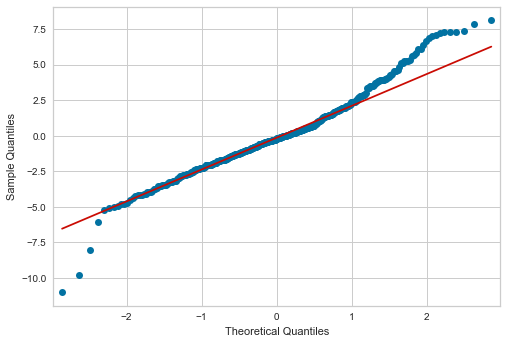

In [332]:
res = dassa_model.resid.values # residuals with a qq plot
fig = sm.qqplot(res,line = 'q')
fig.show()

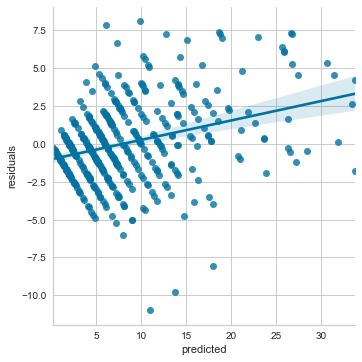

In [333]:
performance = pd.DataFrame()
performance["residuals"] = dassa_model.resid.values
#performance["order"] = all_dat_df.order
performance["predicted"] = dassa_model.fittedvalues

sns.lmplot(x = "predicted", y = "residuals",  data = performance)

In [338]:
#model_norm_dassa= smf.gee("dass_anxiety ~ C(time) + C(Group, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Gaussian()).fit()
model_gamma_dassa = smf.gee("dass_anxiety~ C(time) + C(Group, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Independence(), family = sm.families.Gamma()).fit()

In [339]:
model_gamma_dassa.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: GEE
=================================================================================
Model:                     GEE                    AIC:                  -inf     
Link Function:             inverse_power          BIC:                  1961.3555
Dependent Variable:        dass_anxiety           Log-Likelihood:       inf      
Date:                      2021-10-26 17:38       LL-Null:              inf      
No. Observations:          469                    Deviance:             4809.1   
Df Model:                  5                      Pearson chi2:         442.     
Df Residuals:              463                    Scale:                0.95554  
Method:                    IRLS                                                  
---------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                           0.1175   0.0158  7.4482 0.0000  0.0866 0.1484
C(time)[T.2.0]                     -0.0089   0.0075 -1.1870 0.2352 -0.0237 0.0058
C(time)[T.4.0]                     -0.0094   0.0106 -0.8857 0.3758 -0.0301 0.0114
C(time)[T.12.0]                    -0.0030   0.0105 -0.2854 0.7753 -0.0237 0.0176
C(Group, Treatment('CTR'))[T.EW]    0.0309   0.0277  1.1156 0.2646 -0.0234 0.0853
C(Group, Treatment('CTR'))[T.EWRE]  0.0112   0.0187  0.5998 0.5486 -0.0254 0.0477
=================================================================================

"""

In [341]:
dasss_res, dasss_pvals,dasss_llf,dasss_model = get_res(all_dat_df,'id',"dass_stress ~ C(time) * C(Group, Treatment('CTR'))", "~1+C(time)")
print(dasss_res)

                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             dass_stress
No. Observations:              469                 Method:                         REML       
No. Groups:                    119                 Scale:                          26.5574    
Min. group size:               2                   Log-Likelihood:                 -1576.3374 
Max. group size:               4                   Converged:                      Yes        
Mean group size:               3.9                                                            
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           16.150    1.384 11.665 0.00

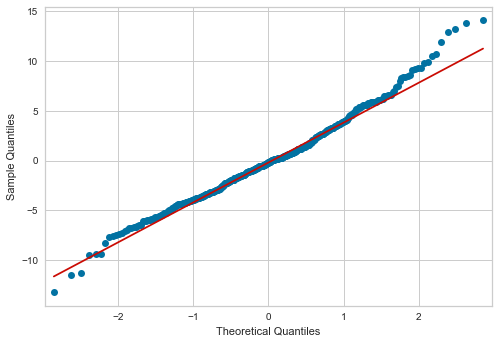

In [342]:
res = dasss_model.resid.values # residuals with a qq plot
fig = sm.qqplot(res,line = 'q')
fig.show()

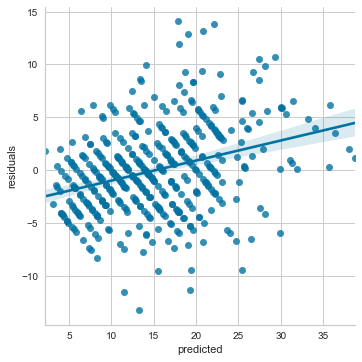

In [343]:
performance = pd.DataFrame()
performance["residuals"] = dasss_model.resid.values
#performance["order"] = all_dat_df.order
performance["predicted"] = dasss_model.fittedvalues

sns.lmplot(x = "predicted", y = "residuals",  data = performance)

We now use GLMs. Due to the distribution of the response variable (discrete, 0-bounded), we will use the negative binomial distribution in our model

In [344]:
model_norm_dasss= smf.gee("dass_depression ~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Gaussian()).fit()
model_gamma_dasss = smf.gee("dass_depression~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Independence(), family = sm.families.Gamma()).fit()


See here about comparing deviance between models:
https://stats.stackexchange.com/questions/83990/deviance-in-generalized-linear-models-for-different-families

In [347]:
model_norm_dasss.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: GEE
==================================================================================================
Model:                           GEE                         AIC:                       3511.7287 
Link Function:                   identity                    BIC:                       43784.1253
Dependent Variable:              dass_depression             Log-Likelihood:            -1743.9   
Date:                            2021-10-26 17:40            LL-Null:                   -1752.0   
No. Observations:                469                         Deviance:                  46595.    
Df Model:                        11                          Pearson chi2:              4.66e+04  
Df Residuals:                    457                         Scale:                     101.96    
Method:                          IRLS                                                             
--------------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------------------
Intercept                                          16.6438   1.5758 10.5618 0.0000 13.5552 19.7324
C(time)[T.2.0]                                      0.4261   1.7445  0.2443 0.8070 -2.9931  3.8453
C(time)[T.4.0]                                     -3.0858   1.6747 -1.8426 0.0654 -6.3681  0.1965
C(time)[T.12.0]                                    -0.4876   1.8108 -0.2693 0.7877 -4.0367  3.0615
C(Group, Treatment('CTR'))[T.EW]                   -3.7043   2.2213 -1.6677 0.0954 -8.0579  0.6493
C(Group, Treatment('CTR'))[T.EWRE]                 -0.4503   2.3606 -0.1908 0.8487 -5.0771  4.1765
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EW]    -1.4778   2.2785 -0.6486 0.5166 -5.9436  2.9880
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EW]     3.6920   2.4390  1.5138 0.1301 -1.0882  8.4723
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EW]   -1.5396   2.7512 -0.5596 0.5758 -6.9318  3.8527
C(time)[T.2.0]:C(Group, Treatment('CTR'))[T.EWRE]  -1.2802   2.2670 -0.5647 0.5723 -5.7236  3.1631
C(time)[T.4.0]:C(Group, Treatment('CTR'))[T.EWRE]   2.6438   2.4824  1.0650 0.2869 -2.2216  7.5092
C(time)[T.12.0]:C(Group, Treatment('CTR'))[T.EWRE] -3.0638   2.6846 -1.1412 0.2538 -8.3255  2.1980
==================================================================================================

"""

In [348]:
print(model_norm_dassd.deviance, model_norm_dassd.qic())
print(model_gamma_dassd.deviance, model_gamma_dassd.qic())

46995.516006266975 (481.0145185634802, 474.99999998843253)
1984.5617311836097 (15571.562280913808, 10953.146977567854)


NB: Model selection for GEEs https://www.tandfonline.com/doi/full/10.1080/03610910701539617

<AxesSubplot:ylabel='Density'>

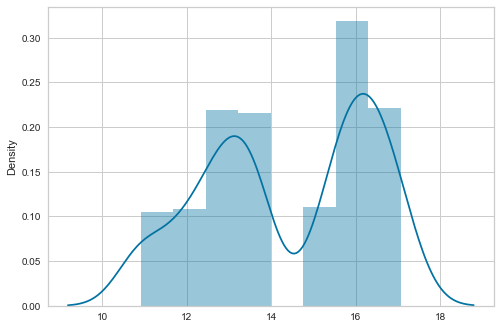

In [350]:
sns.distplot(model_norm_dasss.fittedvalues,color = 'b')

<AxesSubplot:xlabel='dass_stress', ylabel='Density'>

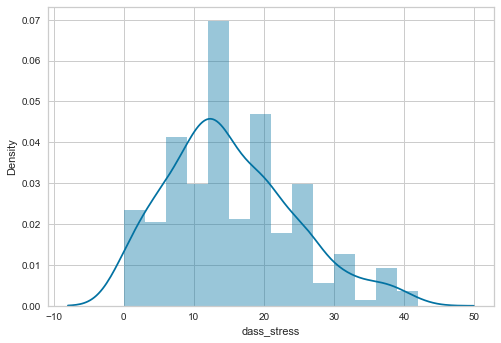

In [351]:
sns.distplot(all_dat_df.dass_stress,color = 'b')

In [118]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
all_dat_df['ERQ_reapp_scaled'] = scaler.fit_transform(all_dat_df.ERQ_reapp.values.reshape(-1,1))
all_dat_df['ERQ_sup_scaled'] = scaler.fit_transform(all_dat_df.ERQ_sup.values.reshape(-1,1))
all_dat_df['RRS_scaled'] = scaler.fit_transform(all_dat_df.RRS_total.values.reshape(-1,1))
all_dat_df['SOC_scaled'] = scaler.fit_transform(all_dat_df.SOC.values.reshape(-1,1))